# N-BaIoT: Network-based Detection of IoT Botnet Attacks Using Deep Autoencoders
## Yair Meidan, Michael Bohadana, Yael Mathov, Yisroel Mirsky, Dominik Breitenbacher, Asaf Shabtai, and Yuval Elovici
## IEEE PERVASIVE COMPUTING, VOL. 13, NO. 9, JULY-SEPTEMBER 2018
## [Dataset available](http://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT#)

## Data Sources
- Traffic Collected from 2 separate Botnet Attacks across 9 devices
 - Mirai
    - Danmini Doorbell
    - Ecobee Thermostat
    - Ennio Dorbell
    - Philips B120N10 Baby Monitor
    - Provision PT_737E Security Camera
    - Provision PT_838 Security Camera
    - Simplehome XCS_1002_WHT Security Camera
    - Simplehome XCS_1003_WHT Security Camera
 - Bashlite
    - Danmini Doorbell
    - Ecobee Thermostat
    - Philips B120N10 Baby Monitor
    - Provision PT_737E Security Camera
    - Provision PT_838 Security Camera
    - Samsung SNH_1011_N Webcam
    - Simplehome XCS_1002_WHT Security Camera
    - Simplehome XCS_1003_WHT Security Camera

## Attribute Description (From "N-BaIoT: Network-based Detection of IoT Botnet Attacks Using Deep Autoencoders")
- The following describes each of the features headers:
 - Stream aggregation:
	- H: ("Source IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP)
	- MI: ("Source MAC-IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP + MAC)
	- HH: ("Channel" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host (IP) to the 
	packet's destination host.
	- HH_jit: ("Channel jitter" in N-BaIoT paper) Stats summarizing the jitter of the traffic going from this packet's
	 host (IP) to the packet's destination host.
	- HpHp: ("Socket" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host+port (IP) 
	to the packet's destination host+port. Example 192.168.4.2:1242 -> 192.168.4.12:80
- Time-frame (The decay factor Lambda used in the damped window): 
	- How much recent history of the stream is capture in these statistics
	- L5, L3, L1, L0.1 and L0.01
- The statistics extracted from the packet stream:
	- weight: The weight of the stream (can be viewed as the number of items observed in recent history)
	- mean: ...
	- std: ...
	- radius: The root squared sum of the two streams' variances
	- magnitude: The root squared sum of the two streams' mea  ns 
	- cov: An approximated covariance between two streams
	- pcc: An approximated correlation coefficient between two streams   

In [143]:
import dask.dataframe as dd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [144]:
bashlite_devices = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

mirai_devices = ['danmini_doorbell', 'ecobee_thermostat', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

benign = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

bashlite_attacks = ['scan', # scanning a network for vulnerable devices
                    'junk', # sending spam data
                    'udp', # udp flood
                    'tcp', # tcp flood
                    'combo'] # sending spam data and opening connection to specific ip/port

mirai_attacks = ['ack', # automatic scan for vulnerable devices
                 'scan', # ack flood
                 'syn', # syn flood
                 'udp', # udp flood
                 'udpplain'] # optimized udp flood

In [145]:
bashlite_attack_data = {}
for device in bashlite_devices:
    bashlite_attack_data[device] = {}
    for attack in bashlite_attacks:
        data = dd.read_csv(f'../data/n_balo_t/{device}/gafgyt_attacks/{attack}.csv')
        bashlite_attack_data[device][attack] = data
        #print(f'BASHLITE: {device} - {attack} - malign data instances: {data.shape[0].compute()}')
        
mirai_attack_data = {}
for device in mirai_devices:
    mirai_attack_data[device] = {}
    for attack in mirai_attacks:
        data = dd.read_csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
        mirai_attack_data[device][attack] = data
        #print(f'MIRAI: {device} - {attack} - malign data instances: {data.shape[0].compute()}')
        
benign_traffic_data = {}
for device in benign:
    benign_traffic_data[device] = dd.read_csv(f'../data/n_balo_t/{device}/benign_traffic.csv')

In [146]:
# data balance check for mirai devices benign traffic
m_benign_instances = []
for device in mirai_devices:
    m_benign_instances.append(benign_traffic_data[device].shape[0].compute())

In [147]:
# data balance check for mirai
m_malicious = []
for device in mirai_devices:
    total_malign = 0
    current_device = mirai_attack_data[device]
    for attack in mirai_attacks:
        counted = current_device[attack].shape[0].compute()
        total_malign += counted
    m_malicious.append(total_malign)

0: danmini_doorbell
1: ecobee_thermostat
2: philips_B120N10_baby_monitor
3: provision_PT_737E_security_camera
4: provision_PT_838_security_camera
5: simplehome_XCS_1002_WHT_security_camera
6: simplehome_XCS_1003_WHT_security_camera


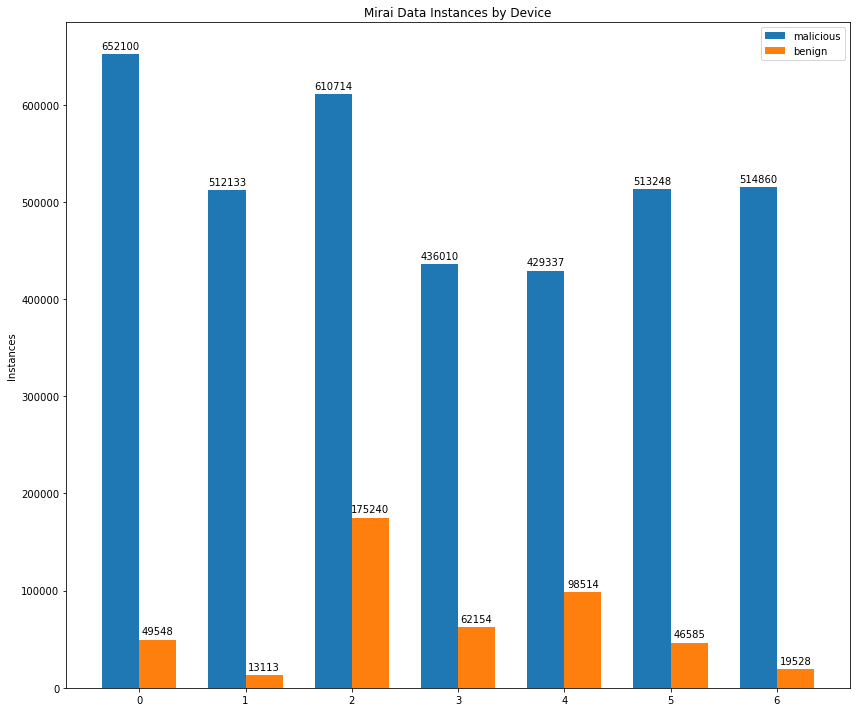

In [148]:
labels = [x for x in range(len(mirai_devices))]

for x in labels:
    print(f'{x}: {mirai_devices[x]}')

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,10))
rects1 = ax.bar(x - width/2, m_malicious, width, label='malicious')
rects2 = ax.bar(x + width/2, m_benign_instances, width, label='benign')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Instances')
ax.set_title('Mirai Data Instances by Device')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [149]:
# data balance check for bashlite devices benign traffic
b_benign_instances = []
for device in bashlite_devices:
    b_benign_instances.append(benign_traffic_data[device].shape[0].compute())

In [150]:
# data balance check for bashlite
b_malicious = []
for device in bashlite_devices:
    total_malign = 0
    current_device = bashlite_attack_data[device]
    for attack in bashlite_attacks:
        counted = current_device[attack].shape[0].compute()
        total_malign += counted
    b_malicious.append(total_malign)

0: danmini_doorbell
1: ecobee_thermostat
2: ennio_doorbell
3: philips_B120N10_baby_monitor
4: provision_PT_737E_security_camera
5: provision_PT_838_security_camera
6: samsung_SNH_1011_N_webcam
7: simplehome_XCS_1002_WHT_security_camera
8: simplehome_XCS_1003_WHT_security_camera


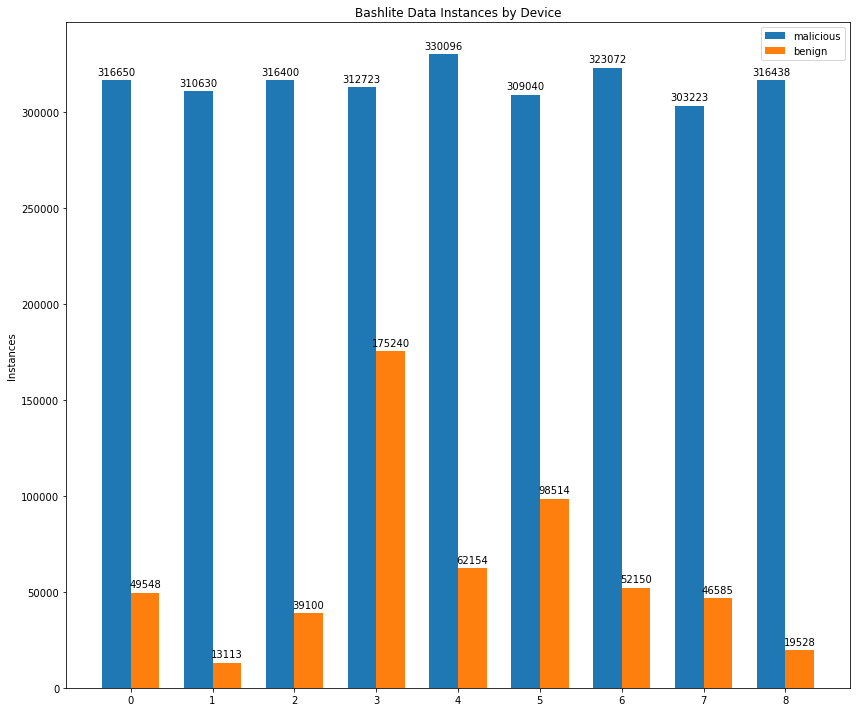

In [151]:
labels = [x for x in range(len(bashlite_devices))]
for x in labels:
    print(f'{x}: {bashlite_devices[x]}')

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,10))
rects1 = ax.bar(x - width/2, b_malicious, width, label='malicious')
rects2 = ax.bar(x + width/2, b_benign_instances, width, label='benign')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Instances')
ax.set_title('Bashlite Data Instances by Device')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

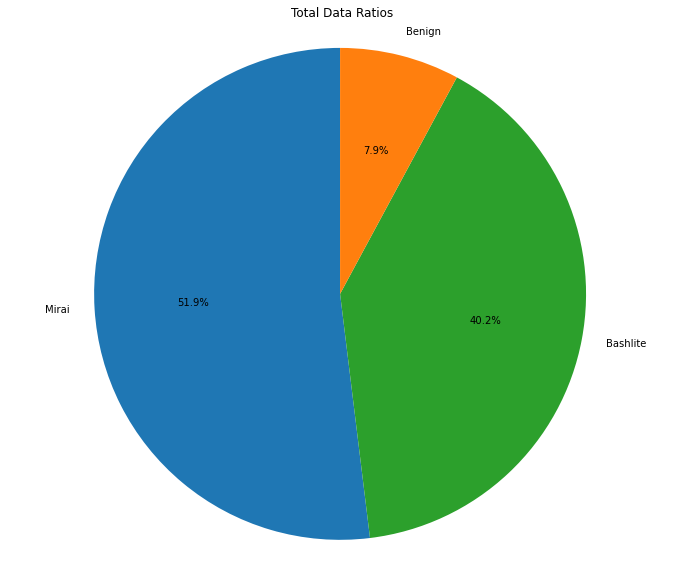

In [160]:
# data balance pie
labels = 'Mirai', 'Bashlite', 'Benign'
sizes = [sum(m_malicious), sum(b_malicious), sum(b_benign_instances)]

fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Total Data Ratios')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tab:blue', 'tab:green', 'tab:orange'])
ax1.axis('equal')
plt.show()

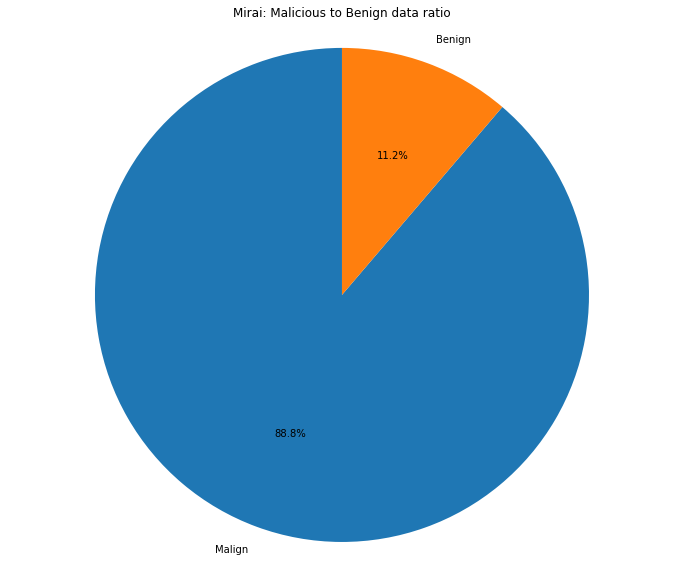

In [161]:
# mirai malign to benign ratio
labels = 'Malign', 'Benign'
sizes = [sum(m_malicious), sum(m_benign_instances)]

fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Mirai: Malicious to Benign data ratio')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tab:blue', 'tab:orange'])
ax1.axis('equal')
plt.show()

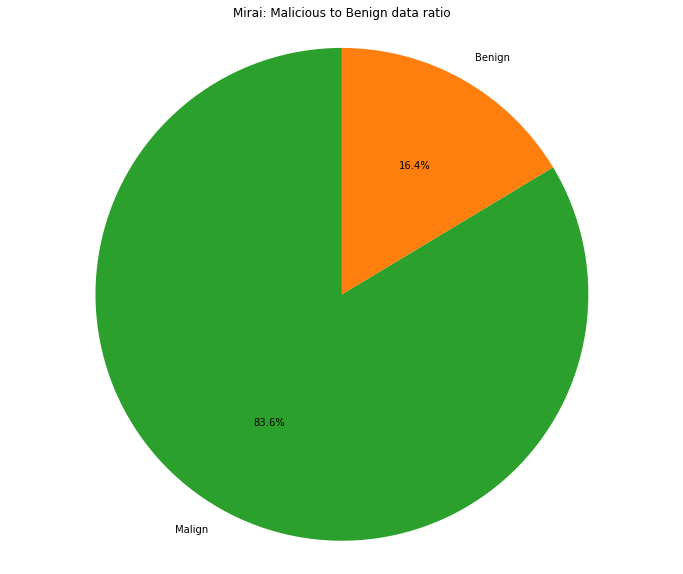

In [159]:
# bashlite malign to benign ratio
# mirai malign to benign
labels = 'Malign', 'Benign'
sizes = [sum(b_malicious), sum(b_benign_instances)]

fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Mirai: Malicious to Benign data ratio')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tab:green', 'tab:orange'])
ax1.axis('equal')
plt.show()